# Water detection with Sentinel-1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc)

## Background

Over 40% of the world’s population lives within 100 km of the coastline.
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats.
Updating data on the position of the coastline is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

While coastlines can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](../Real_world_examples/Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below.
This can be a particular problem in cloudy regions or areas where clouds in wet season prevent optical satellites from taking clear images for many months of the year.

Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather.
Radar data is readily available from the ESA Copernicus program's Sentinel-1 satellites.
The two satellites provide all-weather observations, with a revisit time of 6 days.
By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.
For more information, see the [Sentinel-1](../Datasets/Sentinel_1.ipynb) notebook.

## Description

In this example, we use data from the Sentinel-1 satellites to build a classifier that can determine whether a pixel is a water or land in radar data.
Specifically, this notebook uses an analysis-ready radar product known as backscatter, which describes the strength of the signal received by the satellite.

The notebook contains the following steps:

1. Load Sentinel-1 backscatter data for an area of interest
2. Visualise the returned data with histogram analysis for Sentinel-1 Dataset
3. Applying speckle filtering to Sentinel-1 as a pre-processing step
4. Converting the digital numbers to dB values in each pixel 
4. Use threshold values to separate water and non-water areas
5. Design a classifier to distinguish land and water
5. Apply the classifier to the area of interest and interpret the results

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import warnings 
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from scipy.ndimage import grey_dilation, grey_erosion
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from scipy.signal import argrelextrema
from skimage.morphology import disk
from astropy.stats import histogram 
warnings.filterwarnings("ignore")

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import display_map, rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Radar_water_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2020') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the coast of Gomoa Fetteh, Ghana.

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Sentinel-1 (`s1_rtc`). 

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Define the area of interest
lat = 12.62 
lon = -16.29  
buffer = 0.05

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

#timeframe
timerange = ('2020')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest. This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. When working with Sentinel-1, the function will also combine and sort images from both Sentinel-1A and Sentinel-1B.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              output_crs = "EPSG:6933",
              resolution = (-20,20),
              group_by="solar_day",
              dtype='native'
             )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 31 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument reveals the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
print(S1)

<xarray.Dataset>
Dimensions:      (time: 31, x: 484, y: 623)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:17:46.582116 ... 2020-12...
  * y            (y) float64 1.604e+06 1.604e+06 ... 1.591e+06 1.591e+06
  * x            (x) float64 -1.577e+06 -1.577e+06 ... -1.567e+06 -1.567e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.05975673 0.0435871 ... 0.15205307
    vh           (time, y, x) float32 0.0053687547 0.004237416 ... 0.017334858
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Coastal and wetland dynamic environments 

Coastal and wetlands are highly dynamic, so cloud-free assessment of radar is valuable to capture change in all seasons. SAR, with its cloud-penetrating capabilities, is well suited to map and monitor dynamic changes in the water extent. In the next few cells, a time series of Sentinel-1 in this part of the Gambia is demonstrated in different polarisation bands.

It is also worth mentioning that the method used in the following analysis does not work for water area with standing vegetation. This will result in a difference in observation when comparing to an optically mapped extent. 

In [7]:
#Selecting a few images from the loaded S1 to visualise 
timesteps = [2,4,6,9,11]
# VH/VV is a potentially useful third feature after VV and VH 
S1['vh/vv'] = S1.vh/S1.vv

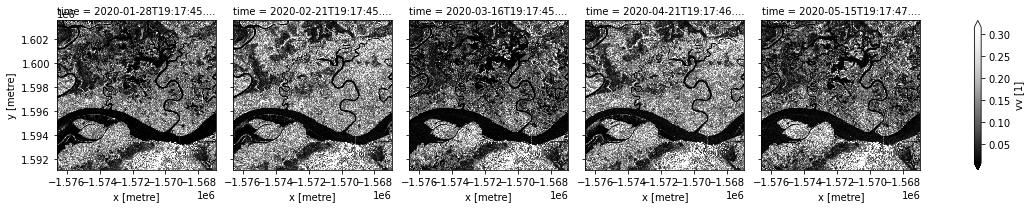

In [8]:
# Plot VH polarisation for specific timeframe 
S1.vv.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

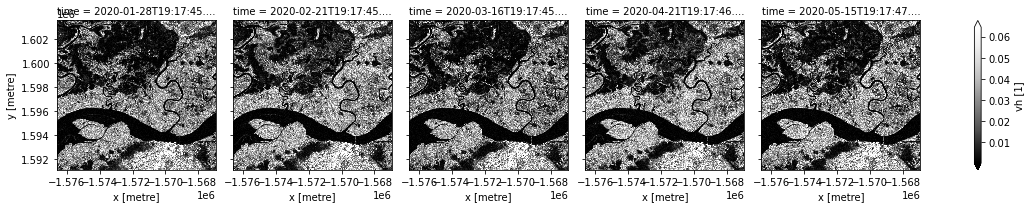

In [9]:
# Plot VH polarisation for specific timeframe 
S1.vh.isel(time=timesteps).plot(cmap="Greys_r", robust=True, col="time", col_wrap=5);

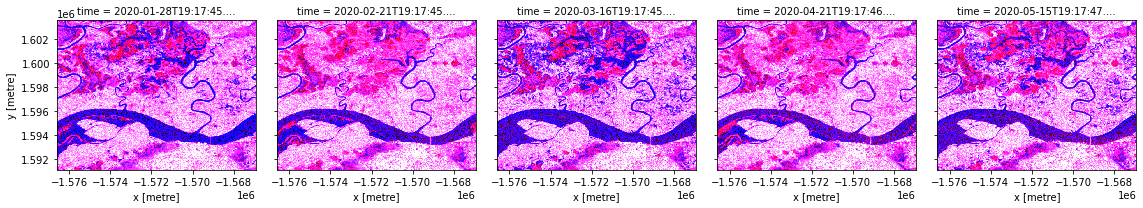

In [10]:
#plotting an RGB image for selected timesteps 
S1[['vv','vh','vh/vv']].to_array().isel(time=timesteps).plot.imshow(col='time',vmin=0,vmax=0.05,col_wrap=5,robust=True);

A Monthly interval of Sentinel-1, shows an area that is undergoing a significant change in extent due to the dynamic behaviour of the wetland.The backscatter properties that we get from this area, confirm rough surface scattering from the ground surface mainly in *VV* polarisation; However, considerable low *VH* polarisation in wetlands along with open water area is more useful in separating water-related features from land in this case.

### Visualise S1 in its two polarisation bands and RGB colour composite 

To see how S1 corresponds with a standard image, we can plot the radar backscatter in each polarisation side-by-side. Please note that the the value range for each polarisation is very different. 

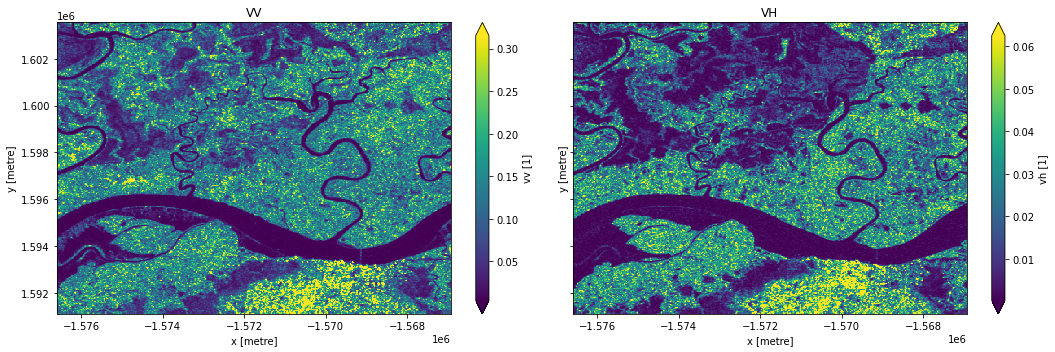

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharey=True)
S1.isel(time=3).vv.plot(ax = ax[0], robust=True)
S1.isel(time=3).vh.plot(ax = ax[1], robust=True)
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

## Apply speckle filtering to the clean the data 

Speckle filtering calculates local area statistics, either in a box shape such as 7 x 7 or through an adaptive approach that estimates areas of local homogeneity. This introduces a degree of spatial averaging. Hence the spatial resolution is reduced by a degree of local smoothing. This type of filtering will remove/reduce negative and extremely high backscatter values.

In [12]:
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [13]:
# Set any null values to 0 before applying the filter to prevent issues
S1 = S1.where(xr.ufuncs.isfinite(S1), 0)

# Create a new entry in dataset corresponding to filtered VV and VH data
S1["filtered_vv"] = S1.vv.groupby("time").apply(lee_filter, size=7)
S1["filtered_vh"] = S1.vh.groupby("time").apply(lee_filter, size=7)

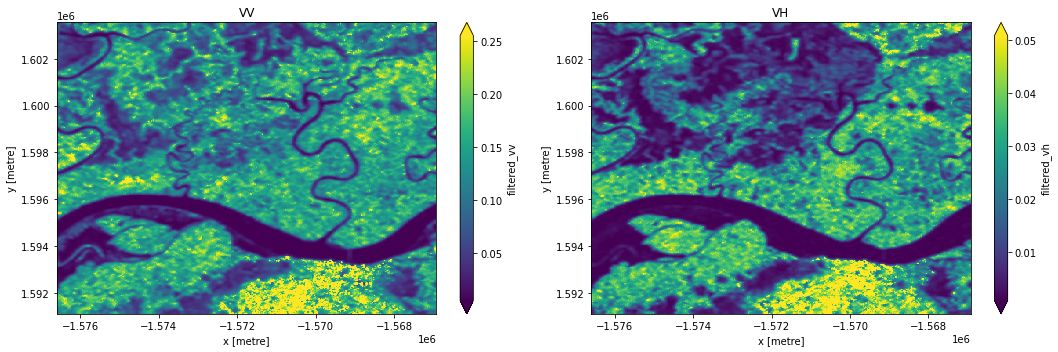

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1["filtered_vv"].isel(time=3).plot(ax = ax[0],robust=True)
S1["filtered_vh"].isel(time=3).plot(ax = ax[1],robust=True);
ax[0].set_title('VV')
ax[1].set_title('VH')
plt.tight_layout();

### Convert the digital numbers to dB

In [15]:
S1['filtered_vv'] = 10 * xr.ufuncs.log10(S1.filtered_vv)
S1['filtered_vh'] = 10 * xr.ufuncs.log10(S1.filtered_vh)

## Histogram analysis for Sentinel-1

To observe the impact of filtering, we can view histograms of the pixel values after filtering for each polarisation bands. Try running the next cell to view the histograms for VH and VV. 

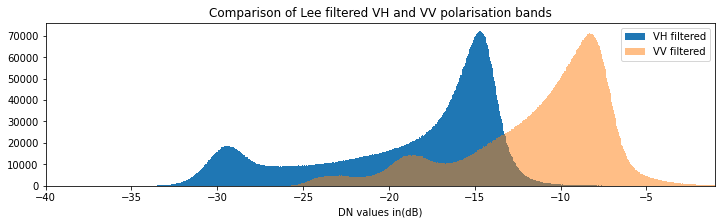

In [16]:
fig = plt.figure(figsize=(12, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
S1.filtered_vv.plot.hist(bins=1000, label="VV filtered",alpha=0.5)
plt.xlim(-40,-1)
plt.legend()
plt.xlabel("DN values in(dB)")
plt.title("Comparison of Lee filtered VH and VV polarisation bands");

## Build and apply the classifier 

Given that the distinction between the `land` and `water` pixel value distributions is strongest in the *VH* band in the area, we'll base our classifier on this distribution.
To separate them, we can choose a threshold: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are several ways to determine the threshold; one is to estimate it by looking at the *VH* histogram.
From this, we might guess that $\text{threshold_vh} = -25$ is a reasonable value and write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
2. Return a data set containing the `water` pixels.

These steps correspond to the actions taken in the function below.

In [17]:
threshold_vh = -25.0

### Visualise threshold

To check if our chosen threshold reasonably divides the two distributions, we can add the threshold to the histogram plots we made earlier. Run the next two cells to view two different visualisations of this.


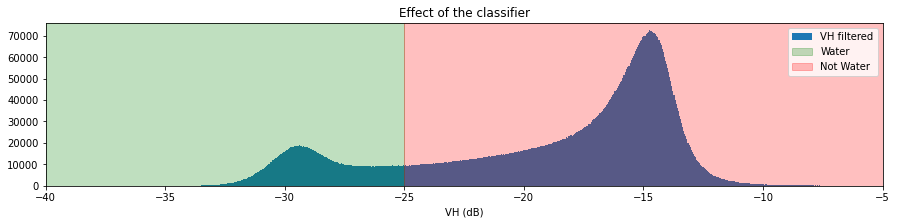

In [18]:
fig, ax = plt.subplots(figsize=(15, 3))
S1.filtered_vh.plot.hist(bins=1000, label="VH filtered")
plt.xlim(-40,-5)
ax.axvspan(xmin=-40.0, xmax=threshold_vh, alpha=0.25, color="green", label="Water")
ax.axvspan(xmin=threshold_vh,
           xmax=-5,
           alpha=0.25,
           color="red",
           label="Not Water")
plt.legend()
plt.xlabel("VH (dB)")
plt.title("Effect of the classifier")
plt.show()

### Define the classifier

In [19]:
def S1_water_classifier(da, threshold=threshold_vh):
    water_data_array = da < threshold
    return water_data_array.to_dataset(name="s1_water")

Now that we have defined the classifier function, we can apply it to the data. After running the classifier, we will able to view the classified data product by running `print(S1.water)`.

In [20]:
S1['water'] = S1_water_classifier(S1.filtered_vh).s1_water

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the boundaries of water features, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.

If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values. In this case study, these pixels are associated with wetland areas. 

The following cell plots the average classified pixel value over time.

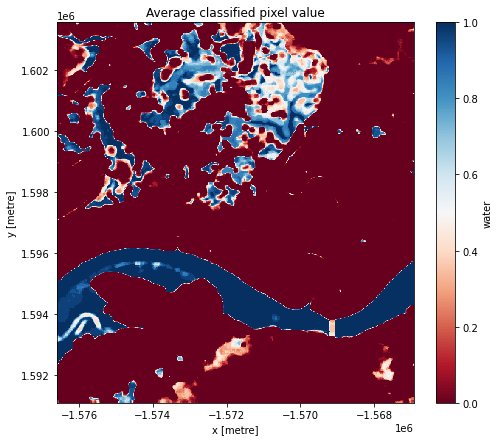

In [21]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
S1.water.mean(dim='time').plot(cmap="RdBu")
plt.title("Average classified pixel value");

You can see that the selected threshold has done a good job of separating the water pixels (in blue) and land pixels (in red) as well as ephemeral water features in between. 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely to due to the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide.



### Assessment with standard deviation

Given that we've identified the shoreline as the pixels that are classified sometimes as land and sometimes as water, we can also see if the standard deviation of each pixel in time is a reasonable way to determine if a pixel is a shoreline or not.

Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the `std` function in place of the `mean` function.

If you'd like to see the results using a different colour scheme, you can also try substituting `cmap="Greys"` or `cmap="Blues"` in place of `cmap="viridis"`.


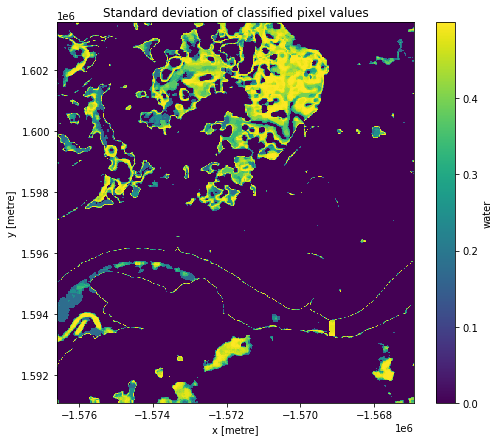

In [22]:
plt.figure(figsize=(8, 7))
S1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values");

The standard deviation we calculated above gives us an idea of how variable a pixel has been over the entire period of time that we looked at. From the image above, you should be able to see that the land and water pixels almost always have a standard deviation of `0`, meaning they didn't change over the time we sampled. Areas over **seasonal wetlands** however have a higher standard deviation, indicating that they change frequently between water and non-water as the seasons change.

An important thing to recognise is that the standard deviation might not be able to detect the difference between noise, tides, and ongoing change, since a pixel that frequently alternates between land and water (noise) could have the same standard deviation as a pixel that is land for some time, then becomes water for the remaining time (ongoing change or tides).

## Next steps

When you are done, return to the "Analysis parameters" section, modify some values (e.g. lat and lon) and rerun the analysis. You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for. You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Sentinel-1 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/s1_rtc/extents).


---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [23]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-06-15'